# ESA PolInSAR & BIOMASS 2023
# 7th Advanced Training Course on Radar Polarimetry
# 12-16 June 2023 - ISAE-SUPAERO, Toulouse, France 
# SAR Tomography

* P-band real TomoSAR data set: Mondah site, AfriSAR campaign
    * 11 images, flown vertical non-uniform displacements: (0, 80, 60, 40, 20, 10, -20, -40, -60, -80, -30)
    * corresponding LVIS ground topography and top canopy height provided
    * slc (hh, hv, vv), kz, flat-earth, and X-band dem are provided
* Path: '/projects/data/tomosar/'

Objective:
- Reconstruct (and compare) the 3D reflectivity distribution by using the Fourier and Capon algorithms.
- Display profiles in the azimuth-height plane, and for multiple range-azimuth planes at different heights.


In [1]:
import sys
sys.path.append('/projects/src/')

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import filters
from ste_io import *
from tqdm import tqdm

%matplotlib widget

In [2]:
# --- inputs 

# path to data
path2data = '/home/data/'
# number of tracks
tracks = 11

# Output range resolution, in meters
resrg = 20.
resaz = 20.

# pixel spacing, m
spacrg = 0.81009310
spacaz = 1.1988876


In [3]:
# --- Calculate number of looks

looksr = int( resrg / spacrg )
if looksr % 2 == 0 : looksr = looksr +1
looksa = int( resaz / spacaz )
if looksa % 2 == 0 : looksa = looksa +1

**Step 1: load data and kz, and compensate flat-earth phase**

In [4]:
# --- load images, compensate DTM and flat-earth and load kz

# --- load dtm 
dtm = rrat(path2data + 'lidar_dtm.rat')

# --- load chm
chm = rrat(path2data + 'lidar_chm.rat')

In [5]:
# get dimensions
dim = dtm.shape
print(dim)

(7000, 2000)


In [6]:
# image selection list
improc = [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
tracks = np.sum(np.asarray(improc))

# initialize slc and kz cube
slc = np.zeros((dim[0], dim[1], tracks), 'complex64')
kz  = np.zeros((dim[0], dim[1], tracks), 'float32')

# read and prepare data
kk = 0
for nn in tqdm( range(len(improc))  ) :
    
    if improc[nn] == 1 :
        
        # read the slc
        slc0 = rrat(path2data + 'slc_' + str(nn).zfill(2) + '_HV.rat')
        # read the fe
        fe = rrat(path2data + 'pha_dem_' + str(nn).zfill(2) + '.rat')
        # compensate fe
        slc[:, :, kk] = slc0 * np.exp(1j * fe)
    
        # read kz
        kz[:, :, kk] = rrat(path2data + 'kz_' + str(nn).zfill(2) + '.rat')
        
        kk = kk + 1
    
del slc0
del fe

100%|█████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.75it/s]


In [7]:
# Crop images in azimuth
crop_az = (2000, 5000)
slc=slc[crop_az[0]:crop_az[1], :,:]
kz=kz[crop_az[0]:crop_az[1], :,:]
dtm=dtm[crop_az[0]:crop_az[1], :]
chm=chm[crop_az[0]:crop_az[1], :]
dim = dtm.shape
print(dim)

(3000, 2000)


**Step 2: display lidar ground topography and top canopy height, and slc**

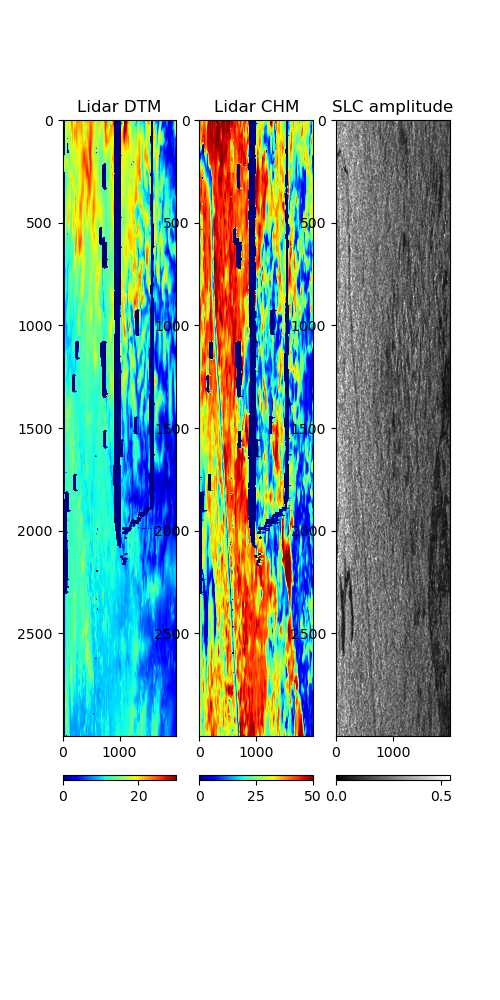

In [8]:
# --- display

plt.figure( figsize = (5, 10))

plt.subplot(1, 3, 1)
plt.imshow(dtm, vmin = 0, vmax = 30, cmap = 'jet', aspect = 'auto')
plt.title('Lidar DTM')
plt.colorbar(orientation = 'horizontal', pad = 0.05)

plt.subplot(1, 3, 2)
plt.imshow(chm, vmin = 0, vmax = 50, cmap = 'jet', aspect = 'auto')
plt.title('Lidar CHM')
plt.colorbar(orientation = 'horizontal', pad = 0.05)

slcamp = np.sqrt( filters.uniform_filter(np.abs(slc[:, :, 0])**2, [5, 5]) )

plt.subplot(1, 3, 3)
plt.imshow(slcamp, vmin = 0, vmax = 2.5*np.mean(slcamp), cmap = 'gray', aspect = 'auto')
plt.title('SLC amplitude')
plt.colorbar(orientation = 'horizontal', pad = 0.05)


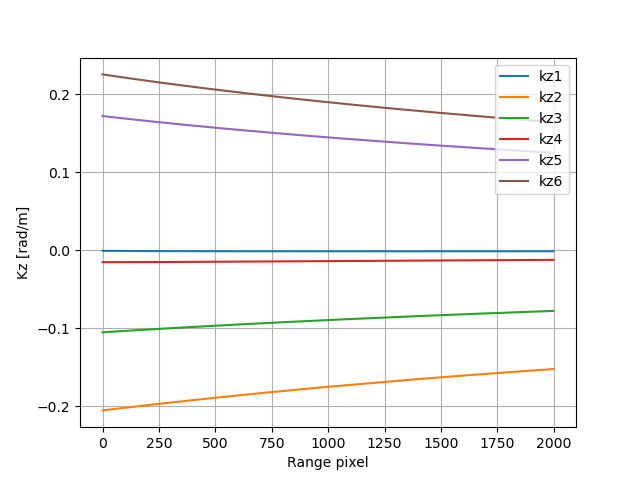

In [9]:
# --- analyse distribution of kz - just average along azimuth

kzmean = np.mean(kz, axis = 0)

# display
plt.figure()
for nn in range(tracks):
    plt.plot(kzmean[:, nn])
plt.grid()
plt.xlabel('Range pixel')
plt.ylabel('Kz [rad/m]')
plt.legend(['kz1','kz2','kz3','kz4','kz5','kz6']);

(2000, 6)


Text(0, 0.5, 'Vertical resolution [m]')

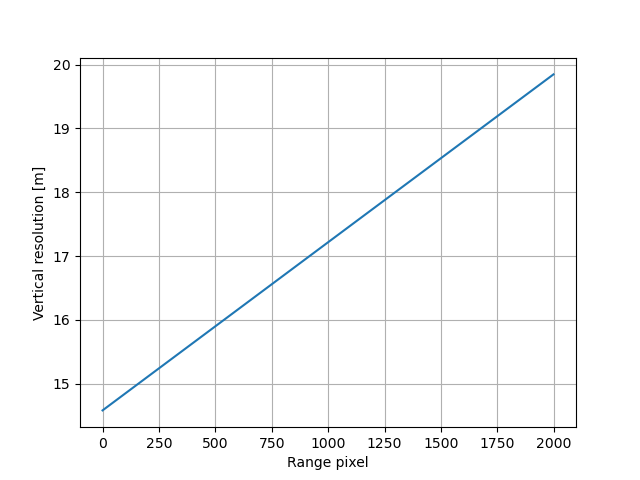

In [10]:
#---calculate vertical resolution along range
print(kzmean.shape)
kzmax=np.amax(kzmean,axis=1)
kzmin=np.amin(kzmean,axis=1)
delta_z=2*np.pi/(kzmax-kzmin)
plt.figure()
plt.plot(delta_z)
plt.grid()
plt.xlabel('Range pixel')
plt.ylabel('Vertical resolution [m]')

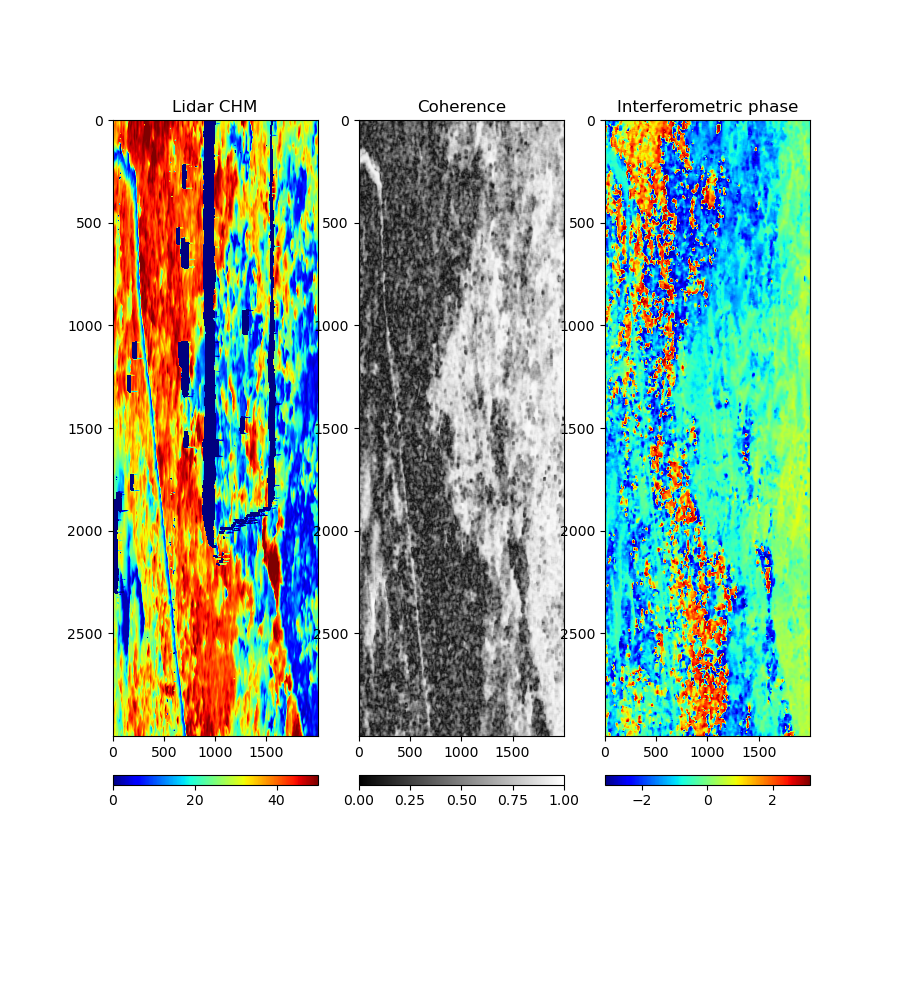

In [11]:
#-- calculate interferometric phase and coherence
im1=slc[:,:,0]
im2=slc[:,:,2]
cov = filters.uniform_filter( np.real(im1 * np.conj(im2)), [looksa, looksr] ) + \
            1j * filters.uniform_filter( np.imag(im1 * np.conj(im2)), [looksa, looksr] )

amp1=np.sqrt( filters.uniform_filter(np.abs(im1)**2, [looksa, looksr]) )
amp2=np.sqrt( filters.uniform_filter(np.abs(im2)**2, [looksa, looksr]) )

coh=cov/(amp1*amp2)


plt.figure( figsize = (9, 10))
plt.subplot(1, 3, 1)
plt.imshow(chm, vmin = 0, vmax = 50, cmap = 'jet', aspect = 'auto')
plt.title('Lidar CHM')
plt.colorbar(orientation = 'horizontal', pad = 0.05)

plt.subplot(1, 3, 2)
plt.imshow(np.abs(coh), vmin = 0, vmax = 1, cmap = 'gray', aspect = 'auto')
plt.title('Coherence')
plt.colorbar(orientation = 'horizontal', pad = 0.05)

plt.subplot(1, 3, 3)
plt.imshow(np.angle(coh), vmin = -np.pi, vmax = np.pi, cmap = 'jet', aspect = 'auto')
plt.title('Interferometric phase')
plt.colorbar(orientation = 'horizontal', pad = 0.05)

**Step 3: calculate Fourier and Capon TomoSAR profiles for every rg-az coordinate (after down-sampling) in HH**

In [12]:
# --- downsample range and azimuth 

rgax = np.linspace(0, dim[1]-1, int(dim[1]/looksr) )
azax = np.linspace(0, dim[0]-1, int(dim[0]/looksa) )
rgax = rgax.astype(int)
azax = azax.astype(int)

# --- make meshgrids

rgm = np.outer(np.ones(azax.size, 'float32'), rgax)
azm = np.outer(azax, np.ones(rgax.size, 'float32'))
rgm = np.reshape(rgm.astype(int), rgm.size)
azm = np.reshape(azm.astype(int), azm.size)

# --- make zaxis 

zaxis = np.linspace(-20, 100, 101)

# --- initialize cubes

cubeF = np.zeros((azax.size, rgax.size, zaxis.size), 'float32')
cubeC = np.zeros((azax.size, rgax.size, zaxis.size), 'float32')

# --- now start to process ...
for nn in tqdm( range(rgm.size) ) :

    ii = np.unravel_index(nn, cubeF[:, :, 0].shape) 
    
    # min / max coordnates for data window 
    minrg = np.clip(rgm[nn] - int(looksr/2), 0, dim[1]-1)
    maxrg = np.clip(rgm[nn] + int(looksr/2), 0, dim[1]-1)
    minaz = np.clip(azm[nn] - int(looksa/2), 0, dim[0]-1)
    maxaz = np.clip(azm[nn] + int(looksa/2), 0, dim[0]-1)
    
    # build data vector
    y = slc[minaz:maxaz+1, minrg:maxrg+1, :]
    y = np.transpose( np.reshape(y, (y.shape[0]*y.shape[1], y.shape[2])) )
    # covariance matrix 
    R = np.dot(y, np.conj(np.transpose(y))) / (y.shape[0]*y.shape[1])
    
    # Select kz + linear phase for all heights
    kkz  = kz[azm[nn], rgm[nn], :]
    amat = np.exp(-1j * np.outer(kkz, zaxis)) 
    
    # Fourier reconstruction
    cubeF[ii[0], ii[1], :] = np.diag( np.linalg.multi_dot([np.conj(np.transpose(amat)), R, amat]) )
    
    # Capon reconstruction
    if np.linalg.det(R) > 0 :
        # diagonal loading
        R = R + 0.05*np.mean(np.diag(R)) * np.eye(tracks)
        Rinv = np.linalg.inv(R)
        # numerator
        wnum = np.dot(Rinv, amat)
        # denominator
        wden = np.diag( np.linalg.multi_dot([np.conj(np.transpose(amat)), Rinv, amat]) )
        wden = np.outer(np.ones(tracks), wden)
        # reference functions: tracks (rows) x heights (columns)
        w = wnum / wden
        # profiles
        cubeC[ii[0], ii[1], :] = np.diag( np.linalg.multi_dot([np.conj(np.transpose(w)), R, w]) )
    

100%|█████████████████████████████████████████████████████| 14080/14080 [00:03<00:00, 3842.72it/s]


**Step 4: compare profiles in representative transects at a fixed range coordinate**

In [13]:
# --- downsample dtm and chm
dtm1 = dtm[azax, :]-4
dtm1 = dtm1[:, rgax]
chm1 = chm[azax, :]
chm1 = chm1[:, rgax]

# --- plot a profile for a fixed range & superimpose dtm and chm

fixrg = 500

# prepare beamforming profile
profF = np.transpose( np.squeeze(cubeF[:, int(fixrg/looksr), :]) )

# prepare capon profile
profC = np.transpose( np.squeeze(cubeC[:, int(fixrg/looksr), :]) )




(0.0, 176.0, -20.0, 100.0)

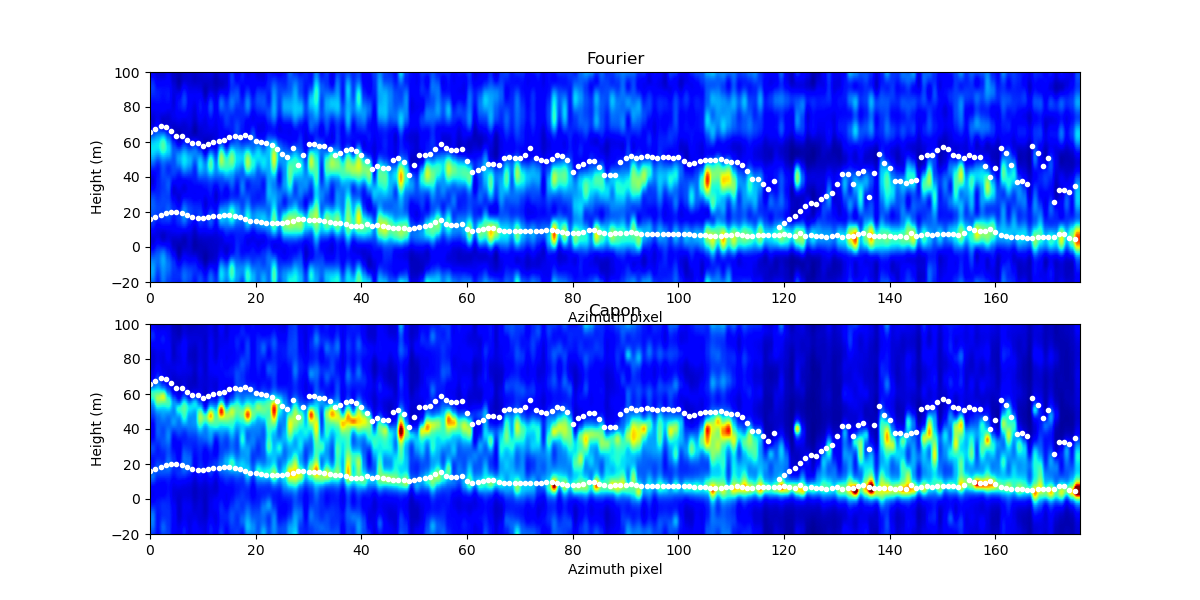

In [14]:
#--display in linear scale
ii = np.where(chm1[:, int(fixrg/looksr)] > -30)
ii = ii[0]
plt.figure(figsize = (12,6))
plt.subplot(2, 1, 1)
plt.imshow(np.flipud(profF), vmin = 0, vmax = 5*np.mean(profF), aspect = 'auto', cmap = 'jet', \
           extent = [0, profF.shape[1], np.min(zaxis), np.max(zaxis)])
plt.title('Fourier')
plt.ylabel('Height (m)')
plt.xlabel('Azimuth pixel')
plt.plot(ii, dtm1[ii, int(fixrg/looksr)], '.', color = 'w')
plt.plot(ii, dtm1[ii, int(fixrg/looksr)] + chm1[ii, int(fixrg/looksr)], '.', color = 'w')
plt.axis([0, profF.shape[1], np.min(zaxis), np.max(zaxis)])

plt.subplot(2, 1, 2)
plt.imshow(np.flipud(profC), vmin = 0, vmax = 5*np.mean(profC), aspect = 'auto', cmap = 'jet', \
           extent = [0, profC.shape[1], np.min(zaxis), np.max(zaxis)]) 
plt.title('Capon')
plt.ylabel('Height (m)')
plt.xlabel('Azimuth pixel')
plt.plot(ii, dtm1[ii, int(fixrg/looksr)], '.', color = 'w')
plt.plot(ii, dtm1[ii, int(fixrg/looksr)] + chm1[ii, int(fixrg/looksr)], '.', color = 'w')
plt.axis([0, profC.shape[1], np.min(zaxis), np.max(zaxis)])

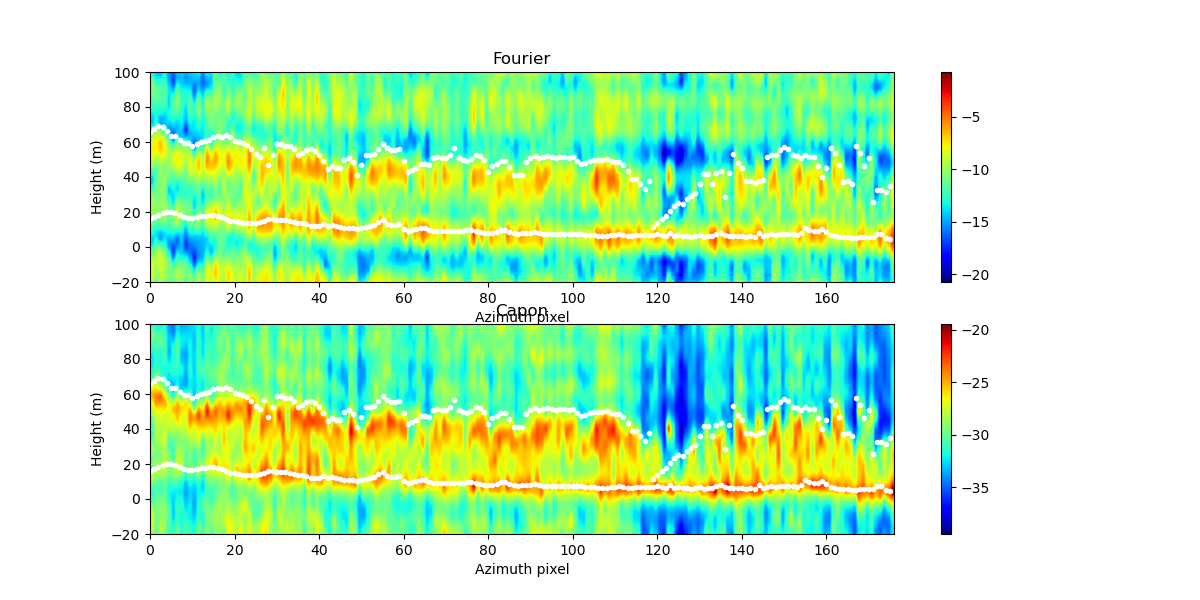

In [15]:
## display in dB
profF_dB=10*np.log10(profF)
mm=np.median(profF_dB)


plt.figure(figsize = (12,6))
plt.subplot(2, 1, 1)
plt.imshow(np.flipud(profF_dB), vmin = mm-10, vmax =mm+10, aspect = 'auto', cmap = 'jet',\
           extent = [0, profF.shape[1], np.min(zaxis), np.max(zaxis)])

plt.title('Fourier')
plt.ylabel('Height (m)')
plt.xlabel('Azimuth pixel')
plt.plot(range(dtm1.shape[0]), dtm1[:, int(fixrg/looksr)], '.', color = 'w')
plt.plot(range(dtm1.shape[0]), dtm1[:, int(fixrg/looksr)] + chm1[ii, int(fixrg/looksr)], '.', color = 'w')
plt.axis([0, profF.shape[1], np.min(zaxis), np.max(zaxis)])
plt.colorbar()

profC_dB=10*np.log10(profC)
mm=np.median(profC_dB)
plt.subplot(2, 1, 2)
plt.imshow(np.flipud(profC_dB), vmin = mm-10, vmax =mm+10, aspect = 'auto', cmap = 'jet',\
           extent = [0, profF.shape[1], np.min(zaxis), np.max(zaxis)])

plt.title('Capon')
plt.ylabel('Height (m)')
plt.xlabel('Azimuth pixel')
plt.plot(range(dtm1.shape[0]), dtm1[:, int(fixrg/looksr)], '.', color = 'w')
plt.plot(range(dtm1.shape[0]), dtm1[:, int(fixrg/looksr)] + chm1[ii, int(fixrg/looksr)], '.', color = 'w')
plt.axis([0, profF.shape[1], np.min(zaxis), np.max(zaxis)])
plt.colorbar()

**Step 5: plot reconstructed reflectivities in rg-az at different heights**

100%|███████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 60.54it/s]


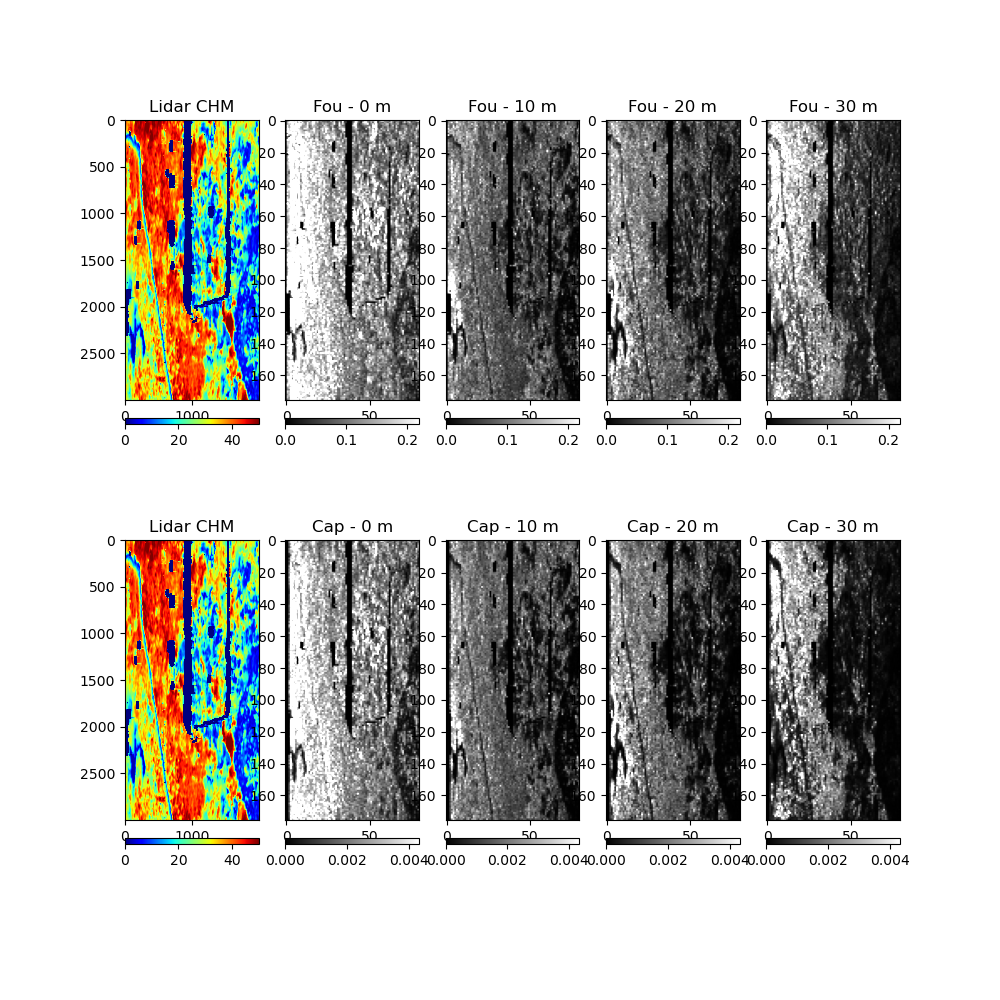

In [16]:
# --- find the heights above the ground

zaxis_0 = [0, 10, 20, 30]

# initialize down-sampled cubes
cubeF_sel = np.zeros((azax.size, rgax.size, len(zaxis_0)), 'float32')
cubeC_sel = np.zeros((azax.size, rgax.size, len(zaxis_0)), 'float32')

# now pick the right height plane above the ground

for mm in tqdm( range(len(zaxis_0)) ) :
    
    ix = ((dtm1 + zaxis_0[mm] - np.min(zaxis)) / (np.max(zaxis) - np.min(zaxis)) * zaxis.size)
    ix = ix.astype(int)
    
    # now move in rg-az
    for aa in range(azax.size) :
        for rr in range(rgax.size) :
            if ix[aa, rr] >= 0 and ix[aa, rr] < zaxis.size :
                cubeF_sel[aa, rr, mm] = cubeF[aa, rr, ix[aa, rr]]
                cubeC_sel[aa, rr, mm] = cubeC[aa, rr, ix[aa, rr]]

# --- display ...

# find max
maxmaxF = 0
maxmaxC = 0
for nn in range(len(zaxis_0)) :
    if np.mean(cubeF_sel[:,:,nn]) > maxmaxF : maxmaxF = np.mean(cubeF_sel[:,:,nn])
    if np.mean(cubeC_sel[:,:,nn]) > maxmaxC : maxmaxC = np.mean(cubeC_sel[:,:,nn])

# now display

plt.figure(figsize = (2*(len(zaxis_0) + 1), 10))

plt.subplot(2, (len(zaxis_0) + 1), 1)
plt.imshow(chm, vmin = 0, vmax = 50, cmap = 'jet', aspect = 'auto')
plt.title('Lidar CHM')
plt.colorbar(orientation = 'horizontal', pad = 0.05)

plt.subplot(2, (len(zaxis_0) + 1), len(zaxis_0) + 1 + 1)
plt.imshow(chm, vmin = 0, vmax = 50, cmap = 'jet', aspect = 'auto')
plt.title('Lidar CHM')
plt.colorbar(orientation = 'horizontal', pad = 0.05)

for nn in range(len(zaxis_0)) :
    
    plt.subplot(2, (len(zaxis_0) + 1), nn+1 + 1)
    plt.imshow(cubeF_sel[:,:,nn], vmin = 0, vmax = 1.5*maxmaxF, cmap = 'gray', aspect = 'auto')
    plt.title('Fou - ' + str(zaxis_0[nn]) + ' m')
    plt.colorbar(orientation = 'horizontal', pad = 0.05)
    
    plt.subplot(2, (len(zaxis_0) + 1), (len(zaxis_0) + 1) + nn + 1 +1)
    plt.imshow(cubeC_sel[:,:,nn], vmin = 0, vmax = 1.7*maxmaxC, cmap = 'gray', aspect = 'auto')
    plt.title('Cap - ' + str(zaxis_0[nn]) + ' m')
    plt.colorbar(orientation = 'horizontal', pad = 0.05)

